In [1]:
#!pip install transformers #for NLP models, if not installed yet
import pandas as pd
import json
import os
import datetime
import yfinance as yf
import numpy as np
from transformers import pipeline
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import requests
import pytz
import langid
import math
import matplotlib.pyplot as plt

<h1>TRADITIONAL FINANCE</h1>

In [2]:
# Initialize an empty list to store the extracted data
all_ticker_data = []

# Directory containing the JSON files
directory = './Raw Data'  #Replace './data_folder' with the path to your directory

# Loop through all files in the directory
for filename in os.listdir(directory):
    if filename.startswith('TSLA_') and filename.endswith('.json'):
        filepath = os.path.join(directory, filename)
        
        # Read JSON file
        with open(filepath, 'r') as file:
            data = json.load(file)
        
        # Extract relevant data
        for article in data["feed"]:
            time_published = article["time_published"]
            title = article["title"]
            ticker_sentiment = article["ticker_sentiment"]
            
            # Extract ticker sentiment data for TSLA for each article
            for ticker_entry in ticker_sentiment:
                if ticker_entry["ticker"] == "TSLA" and ticker_entry["relevance_score"] >= "0.80":
                    ticker_data = {
                        "date": time_published,
                        "title": title,
                        "ticker": ticker_entry["ticker"],
                        "relevance_score": float(ticker_entry["relevance_score"])
                    }
                    all_ticker_data.append(ticker_data)

# Create DataFrame
df = pd.DataFrame(all_ticker_data)
tradfi_df = df.drop(['relevance_score'], axis=1)
# df_sorted = tradfi_df.sort_values(by='date')
tradfi_df['date'] = pd.to_datetime(tradfi_df['date']).dt.date

#print(df)
tradfi_df.drop_duplicates(subset=['title'], inplace=True)
tradfi_df.sort_values(['date'], inplace=True)
tradfi_df.reset_index(inplace=True, drop=True)
tradfi_df

,date,title,ticker
0,2023-01-01,Where Does Tesla Stock Go in 2023?,TSLA
1,2023-01-02,Elon Musk has lost a bigger fortune than anyon...,TSLA
2,2023-01-02,3 Growth Stocks Down 50% to 69% to Buy Now,TSLA
3,2023-01-02,"Tesla reports 1.31 million deliveries in 2022,...",TSLA
4,2023-01-02,"Tesla Deliveries Hit Record 405,278, But Miss ...",TSLA
...,...,...,...
1411,2024-03-19,Is Tesla Stock A Buy Or A Sell As Negative Hea...,TSLA
1412,2024-03-19,Jim Cramer Calls The Bottom In Tesla Stock: Wh...,TSLA
1413,2024-03-20,Tesla Bull Recommends A 'Great Deal' For Elon ...,TSLA
1414,2024-03-20,Tesla Is Raising Vehicle Prices But Will Consu...,TSLA


<h1>FINANCIAL SENTIMENT MODEL 1: DISTILROBERTA (DR)</h1>

In [3]:
model_list = [# {'model':"ProsusAI/finbert", 'name': "finbert_fin"},
                {'model': "mrm8488/distilroberta-finetuned-financial-news-sentiment-analysis", 'name': "distilroberta_fin"},
              #  {'model': "yiyanghkust/finbert-tone", 'name': "finbert_tone"},
              #  {'model': "soleimanian/financial-roberta-large-sentiment", 'name': "roberta_fin"}
              ]

for model_choice in model_list:
  # nlp-ing
    tokenizer = AutoTokenizer.from_pretrained(model_choice['model'])
    model = AutoModelForSequenceClassification.from_pretrained(model_choice['model'])
    nlp = pipeline('sentiment-analysis', model=model, tokenizer=tokenizer)
    tradfi_df['results'] = tradfi_df['title'].apply(nlp)
    tradfi_df['positive_aggscore'] = tradfi_df['results'].apply(lambda x: sum(entry['score'] for entry in x if entry['label'] == 'positive'))
    tradfi_df['neutral_aggscore'] = tradfi_df['results'].apply(lambda x: sum(entry['score'] for entry in x if entry['label'] == 'neutral'))
    tradfi_df['negative_aggscore'] = tradfi_df['results'].apply(lambda x: sum(entry['score'] for entry in x if entry['label'] == 'negative'))
    tradfi_df['positive_count'] = tradfi_df['results'].apply(lambda x: sum(1 for entry in x if entry['label'] == 'positive'))
    tradfi_df['neutral_count'] = tradfi_df['results'].apply(lambda x: sum(1 for entry in x if entry['label'] == 'neutral'))
    tradfi_df['negative_count'] = tradfi_df['results'].apply(lambda x: sum(1 for entry in x if entry['label'] == 'negative'))
    dr_output_df = tradfi_df.drop(['title', 'results'], axis=1).groupby(['date', 'ticker']).sum()
    dr_output_df.reset_index(inplace=True)

<h1>FINANCIAL SENTIMENT MODEL 2: ProsusAI/FINBERT (PF)</h1>

In [5]:
model_list = [{'model':"ProsusAI/finbert", 'name': "finbert_fin"},
                # {'model': "mrm8488/distilroberta-finetuned-financial-news-sentiment-analysis", 'name': "distilroberta_fin"},
              #  {'model': "yiyanghkust/finbert-tone", 'name': "finbert_tone"},
              #  {'model': "soleimanian/financial-roberta-large-sentiment", 'name': "roberta_fin"}
              ]

for model_choice in model_list:
  # nlp-ing
    tokenizer = AutoTokenizer.from_pretrained(model_choice['model'])
    model = AutoModelForSequenceClassification.from_pretrained(model_choice['model'])
    nlp = pipeline('sentiment-analysis', model=model, tokenizer=tokenizer)
    tradfi_df['results'] = tradfi_df['title'].apply(nlp)
    tradfi_df['positive_aggscore'] = tradfi_df['results'].apply(lambda x: sum(entry['score'] for entry in x if entry['label'] == 'positive'))
    tradfi_df['neutral_aggscore'] = tradfi_df['results'].apply(lambda x: sum(entry['score'] for entry in x if entry['label'] == 'neutral'))
    tradfi_df['negative_aggscore'] = tradfi_df['results'].apply(lambda x: sum(entry['score'] for entry in x if entry['label'] == 'negative'))
    tradfi_df['positive_count'] = tradfi_df['results'].apply(lambda x: sum(1 for entry in x if entry['label'] == 'positive'))
    tradfi_df['neutral_count'] = tradfi_df['results'].apply(lambda x: sum(1 for entry in x if entry['label'] == 'neutral'))
    tradfi_df['negative_count'] = tradfi_df['results'].apply(lambda x: sum(1 for entry in x if entry['label'] == 'negative'))
    pf_output_df = tradfi_df.drop(['title', 'results'], axis=1).groupby(['date', 'ticker']).sum()
    pf_output_df.reset_index(inplace=True)

<h1>YAHOO FINANCE CODE</h1>

In [6]:
price_df = yf.download('TSLA', start='2022-12-31', end='2024-01-01')
close_price_df_raw = price_df[['Close']]
close_price_df_raw

close_price_df_pct_change = close_price_df_raw.pct_change()
close_price_df_pct_change.rename(columns={"Close": "pct_change"}, inplace=True)
close_price_df = pd.concat([close_price_df_raw, close_price_df_pct_change], axis=1)
close_price_df = close_price_df.iloc[1:]
close_price_df.reset_index(inplace=True)

# price % change to change, to be optimized based on performance in model training
def price_cat(price):
    if price >= 0.035:
        return 'buy'
    elif price < -0.035:
        return 'sell'
    else:
        return 'neutral'

# def price_cat(price):
#     if price >= 0:
#         return 'buy'
#     else:
#         return 'sell'
        
close_price_df['signal'] = close_price_df['pct_change'].apply(price_cat)
# close_price_d1_df = close_price_df
# close_price_d1_df['Date'] = close_price_d1_df['Date'] - pd.Timedelta(1, unit='D')

# # close_price_d1_df
# close_price_df = close_price_d1_df
close_price_df

[*********************100%%**********************]  1 of 1 completed


,Date,Close,pct_change,signal
0,2023-01-04,113.639999,0.051249,buy
1,2023-01-05,110.339996,-0.029039,neutral
2,2023-01-06,113.059998,0.024651,neutral
3,2023-01-09,119.769997,0.059349,buy
4,2023-01-10,118.849998,-0.007681,neutral
...,...,...,...,...
244,2023-12-22,252.539993,-0.007701,neutral
245,2023-12-26,256.609985,0.016116,neutral
246,2023-12-27,261.440002,0.018822,neutral
247,2023-12-28,253.179993,-0.031594,neutral


<h1>Price Percent change Encoding</h1>

In [7]:
# Assuming price_df and grouped_df are already defined
from sklearn.preprocessing import LabelEncoder

# Convert 'date' column in output_nlp_df to datetime64[ns]
dr_output_df['date'] = pd.to_datetime(dr_output_df['date'])

# Merge the two dataframes based on the 'Date' column
merged_df = pd.merge(close_price_df, dr_output_df, left_on='Date', right_on='date', how='inner')

# Drop the duplicate 'date' and Close price column, if close price needed later on, we can remve again
merged_df = merged_df.drop(['date','Close'],axis=1)

#One Hot encoding to the signal column 
le = LabelEncoder()
merged_df['signal_encoded'] = le.fit_transform(merged_df['signal'])

merged_df #to test different classification models based on this model (6 variables, 1 target output)

,Date,pct_change,signal,ticker,positive_aggscore,neutral_aggscore,negative_aggscore,positive_count,neutral_count,negative_count,signal_encoded
0,2023-01-04,0.051249,buy,TSLA,1.997763,2.776384,2.973027,2,3,3,0
1,2023-01-05,-0.029039,neutral,TSLA,0.999203,4.566586,2.976273,1,5,3,1
2,2023-01-06,0.024651,neutral,TSLA,0.661042,3.999047,5.980021,1,4,6,1
3,2023-01-09,0.059349,buy,TSLA,4.851305,0.999834,0.000000,5,1,0,0
4,2023-01-10,-0.007681,neutral,TSLA,0.948794,0.000000,1.988316,1,0,2,1
...,...,...,...,...,...,...,...,...,...,...,...
216,2023-12-22,-0.007701,neutral,TSLA,1.996309,2.950414,0.000000,2,3,0,1
217,2023-12-26,0.016116,neutral,TSLA,2.980934,0.000000,0.000000,3,0,0,1
218,2023-12-27,0.018822,neutral,TSLA,2.869225,2.933999,0.000000,3,3,0,1
219,2023-12-28,-0.031594,neutral,TSLA,0.991971,0.000000,1.758384,1,0,2,1


In [8]:
#prepare data for model training
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

X = merged_df[['positive_aggscore','neutral_aggscore','negative_aggscore','positive_count','neutral_count','negative_count']]
# X = merged_df[['positive_count','neutral_count','negative_count']]
y = merged_df['signal_encoded']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(176, 6)
(176,)
(45, 6)
(45,)


In [9]:
#Apply StandardScalar, scale each column indivually on train data instead of entire data to avoid creating relationships
#between train and test data
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
columns = ['positive_aggscore', 'neutral_aggscore', 'negative_aggscore','positive_count','neutral_count','negative_count']
# columns = ['positive_count','neutral_count','negative_count']
X_train[columns] = scaler.fit_transform(X_train[columns])
X_test[columns] = scaler.transform(X_test[columns]) #scaled by fitting scale of X_train
X_train

,positive_aggscore,neutral_aggscore,negative_aggscore,positive_count,neutral_count,negative_count
218,1.531458,0.373365,-0.815541,1.556408,0.365669,-0.841255
113,-1.008780,-0.112676,-0.055121,-1.011665,-0.141085,-0.078055
140,-1.008780,-1.152976,-0.036013,-1.011665,-1.154594,-0.078055
122,-1.008780,0.868845,-0.815541,-1.011665,0.872424,-0.841255
162,-1.008780,0.919529,-0.363803,-1.011665,0.872424,-0.078055
...,...,...,...,...,...,...
106,-0.123899,3.006835,-0.036007,-0.155641,2.899442,-0.078055
14,3.037131,5.420528,-0.031465,3.268458,5.433214,-0.078055
92,1.646110,-0.115368,-0.815541,1.556408,-0.141085,-0.841255
179,-1.008780,-1.152976,-0.030371,-1.011665,-1.154594,-0.078055


<h1>Distill/Roberta NLP model with Decision Tree Classifier Model Training & Testing</h1>

In [10]:
#DecisionTreeClassifier Tuning
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import precision_recall_fscore_support, f1_score

decision_tree_dict = {}
best_score = 0

best_f1 = 0
best_score = 0
price_x=[]
accuracyscoreset = []
f1scoreset = []
majority_ratioset = [] #To check whether imbalance data, majority:Minority>4 considered imbalanced
best_params_set = []

for i in range(1,21):
    x = i/400 #0.0025% incremental loop for pct change
    def price_cat(price):
        if price > x:
            return 'buy'
        elif price < -x:
            return 'sell'
        else:
            return 'neutral'
        
    close_price_df['signal'] = close_price_df['pct_change'].apply(price_cat)
    dr_output_df['date'] = pd.to_datetime(dr_output_df['date'])
    merged_df = pd.merge(close_price_df, dr_output_df, left_on='Date', right_on='date', how='inner')
    merged_df = merged_df.drop(['date','Close'],axis=1)
    
    from sklearn.preprocessing import LabelEncoder
    le = LabelEncoder()
    merged_df['signal_encoded'] = le.fit_transform(merged_df['signal'])
    
    columns = ['positive_aggscore', 'neutral_aggscore', 'negative_aggscore','positive_count','neutral_count','negative_count']
    X = merged_df[columns]
    y = merged_df['signal_encoded']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    scaler = StandardScaler()
    X_train[columns] = scaler.fit_transform(X_train[columns])
    X_test[columns] = scaler.transform(X_test[columns]) #scaled by fitting scale of X_train

    for criterion in ['gini', 'entropy', 'log_loss']:
        for max_depth in range(2,30):
            try:
                clf = DecisionTreeClassifier(criterion=criterion)
                clf.fit(X_train, y_train)
                y_pred = clf.predict(X_test)
                f1 = f1_score(y_test, y_pred, average="macro")
    
                if f1 > best_f1:
                    best_score = clf.score(X_test, y_test)
                    best_parameters = {'criterion': criterion, 'max_depth': max_depth}
                    best_f1 = f1
            except Exception as error:
                print("An exception occurred:", error)

    majority_ratio = len(merged_df[merged_df['signal_encoded'] == 1]) / len(merged_df[merged_df['signal_encoded'] == 2])                        
    price_x.append(x)
    accuracyscoreset.append(best_score)
    f1scoreset.append(best_f1)
    majority_ratioset.append(majority_ratio)
    best_params_set.append(best_parameters)                      


priceloop_df_3 = pd.DataFrame({'price_x': price_x,'accuracyscores': accuracyscoreset,'f1score': f1scoreset,'majority_ratio': majority_ratioset,'best_params': best_params_set})
priceloop_df_3            

,price_x,accuracyscores,f1score,majority_ratio,best_params
0,0.0025,0.488889,0.353078,0.123711,"{'criterion': 'entropy', 'max_depth': 6}"
1,0.0050,0.577778,0.559649,0.348315,"{'criterion': 'log_loss', 'max_depth': 24}"
2,0.0075,0.577778,0.559649,0.554217,"{'criterion': 'log_loss', 'max_depth': 24}"
3,0.0100,0.577778,0.559649,0.837838,"{'criterion': 'log_loss', 'max_depth': 24}"
4,0.0125,0.577778,0.559649,1.169231,"{'criterion': 'log_loss', 'max_depth': 24}"
5,0.0150,0.577778,0.559649,1.568966,"{'criterion': 'log_loss', 'max_depth': 24}"
6,0.0175,0.600000,0.581569,2.270833,"{'criterion': 'gini', 'max_depth': 19}"
7,0.0200,0.622222,0.596833,2.644444,"{'criterion': 'entropy', 'max_depth': 26}"
8,0.0225,0.711111,0.647619,3.648649,"{'criterion': 'gini', 'max_depth': 7}"
9,0.0250,0.733333,0.692593,3.972222,"{'criterion': 'gini', 'max_depth': 12}"


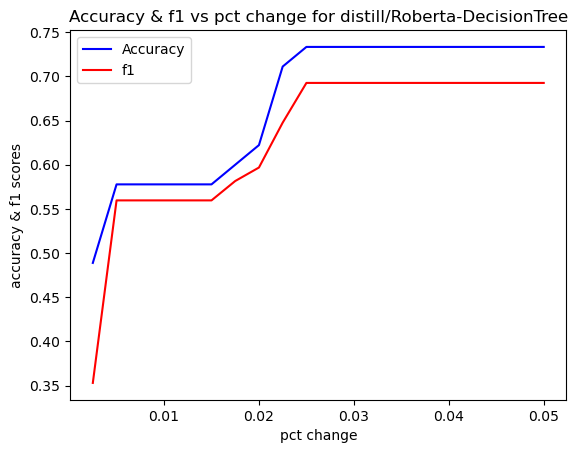

In [11]:
fig, ax = plt.subplots()
ax.plot(priceloop_df_3['price_x'], priceloop_df_3['accuracyscores'], label='Accuracy', color='blue')
ax.plot(priceloop_df_3['price_x'], priceloop_df_3['f1score'], label='f1',color='red')
plt.xlabel('pct change')
plt.ylabel('accuracy & f1 scores')
plt.title('Accuracy & f1 vs pct change for distill/Roberta-DecisionTree')
plt.legend()
plt.show()

<h1>ProsusAI/FinBERT NLP model with Random Forest Classifier Model Training & Testing</h1>

In [12]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, f1_score

#Reiterate with price difference with RandomForestClassifier
price_x =[]
accuracyscoreset = []
f1scoreset = []
majority_ratioset = []

for i in range(1,21):
    x = i/400 #0.0025% incremental loop
    def price_cat(price):
        if price > x:
            return 'buy'
        elif price < -x:
            return 'sell'
        else:
            return 'neutral'
        
    close_price_df['signal'] = close_price_df['pct_change'].apply(price_cat)
    pf_output_df['date'] = pd.to_datetime(pf_output_df['date'])
    merged_df = pd.merge(close_price_df, pf_output_df, left_on='Date', right_on='date', how='inner')
    merged_df = merged_df.drop(['date','Close'],axis=1)
    
    from sklearn.preprocessing import LabelEncoder
    le = LabelEncoder()
    merged_df['signal_encoded'] = le.fit_transform(merged_df['signal'])
    
    columns = ['positive_aggscore', 'neutral_aggscore', 'negative_aggscore','positive_count','neutral_count','negative_count']
    X = merged_df[columns]
    y = merged_df['signal_encoded']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    scaler = StandardScaler()
    X_train[columns] = scaler.fit_transform(X_train[columns])
    X_test[columns] = scaler.transform(X_test[columns]) #scaled by fitting scale of X_train
    
    #Tuning of RandomForest
    for criterion in ['gini', 'entropy']:
        for n_estimator in [200, 300, 400]:
            for max_depth in [None, 10, 20]:
                for min_samples_split in [5, 10, 20]:
                    for min_samples_leaf in [1,2,4]:
                        try:
                            RF = RandomForestClassifier(criterion=criterion, n_estimators=n_estimator,max_depth=max_depth,min_samples_split=min_samples_split,min_samples_leaf=min_samples_leaf)
                            RF.fit(X_train, y_train)
                            y_pred = clf.predict(X_test)
                            f1 = f1_score(y_test, y_pred, average="macro")
    
                            if f1 > best_f1:
                                best_score = RF.score(X_test, y_test)
                                best_parameters = {'criterion': criterion, 'n_estimator': n_estimator, 'max_depth': max_depth, 'min_samples_split': min_samples_split,'min_samples_leaf': min_samples_leaf}
                                y_pred = RF.predict(X_test)
                                best_f1 = f1
                                
                        except Exception as error:
                            print("An exception occurred:", error)    
    
    
    majority_ratio = len(merged_df[merged_df['signal_encoded'] == 1]) / len(merged_df[merged_df['signal_encoded'] == 2])
    f1 = f1_score(y_test,y_pred, average="macro")
    accuracy = accuracy_score(y_test, y_pred)
    price_x.append(x)
    accuracyscoreset.append(accuracy)
    f1scoreset.append(f1)
    majority_ratioset.append(majority_ratio)

priceloop_df_2 = pd.DataFrame({'price_x': price_x,'accuracyscores': accuracyscoreset,'f1score': f1scoreset,'majority_ratio': majority_ratioset,'best_params': best_params_set})
priceloop_df_2

,price_x,accuracyscores,f1score,majority_ratio,best_params
0,0.0025,0.133333,0.142976,0.123711,"{'criterion': 'entropy', 'max_depth': 6}"
1,0.0050,0.244444,0.233120,0.348315,"{'criterion': 'log_loss', 'max_depth': 24}"
2,0.0075,0.311111,0.280618,0.554217,"{'criterion': 'log_loss', 'max_depth': 24}"
3,0.0100,0.377778,0.320884,0.837838,"{'criterion': 'log_loss', 'max_depth': 24}"
4,0.0125,0.422222,0.353489,1.169231,"{'criterion': 'log_loss', 'max_depth': 24}"
5,0.0150,0.466667,0.381303,1.568966,"{'criterion': 'log_loss', 'max_depth': 24}"
6,0.0175,0.511111,0.384134,2.270833,"{'criterion': 'gini', 'max_depth': 19}"
7,0.0200,0.600000,0.437525,2.644444,"{'criterion': 'entropy', 'max_depth': 26}"
8,0.0225,0.555556,0.344211,3.648649,"{'criterion': 'gini', 'max_depth': 7}"
9,0.0250,0.622222,0.378480,3.972222,"{'criterion': 'gini', 'max_depth': 12}"


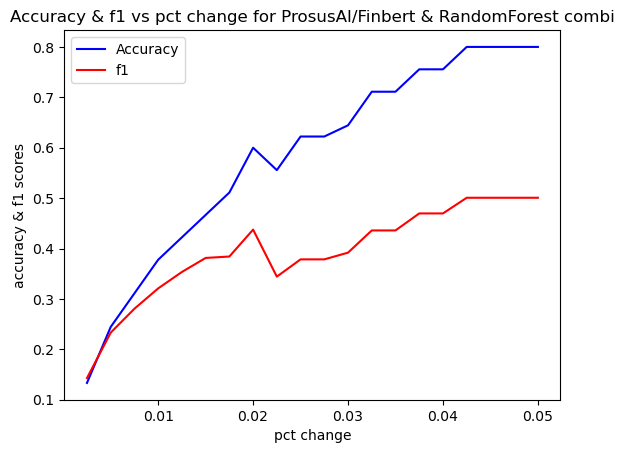

In [13]:
fig, ax = plt.subplots()
ax.plot(priceloop_df_2['price_x'], priceloop_df_2['accuracyscores'], label='Accuracy', color='blue')
ax.plot(priceloop_df_2['price_x'], priceloop_df_2['f1score'], label='f1',color='red')
plt.xlabel('pct change')
plt.ylabel('accuracy & f1 scores')
plt.title('Accuracy & f1 vs pct change for ProsusAI/Finbert & RandomForest combi')
plt.legend()
plt.show()

<h1>Distill/Roberta NLP model with Random Forest Classifier Model Training & Testing</h1>

In [14]:
#RandomForest Classifier Model Tuning
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_recall_fscore_support, f1_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

best_f1 = 0
best_score = 0
price_x=[]
accuracyscoreset = []
f1scoreset = []
majority_ratioset = [] #To check whether imbalance data, majority:Minority>4 considered imbalanced
best_params_set = []

for i in range(1,21):
    x = i/400 #0.0025% incremental loop for pct change
    def price_cat(price):
        if price > x:
            return 'buy'
        elif price < -x:
            return 'sell'
        else:
            return 'neutral'
        
    close_price_df['signal'] = close_price_df['pct_change'].apply(price_cat)
    dr_output_df['date'] = pd.to_datetime(dr_output_df['date'])
    merged_df = pd.merge(close_price_df, dr_output_df, left_on='Date', right_on='date', how='inner')
    merged_df = merged_df.drop(['date','Close'],axis=1)
    
    from sklearn.preprocessing import LabelEncoder
    le = LabelEncoder()
    merged_df['signal_encoded'] = le.fit_transform(merged_df['signal'])
    
    columns = ['positive_aggscore', 'neutral_aggscore', 'negative_aggscore','positive_count','neutral_count','negative_count']
    X = merged_df[columns]
    y = merged_df['signal_encoded']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    scaler = StandardScaler()
    X_train[columns] = scaler.fit_transform(X_train[columns])
    X_test[columns] = scaler.transform(X_test[columns]) #scaled by fitting scale of X_train
    
    #Tuning of Random Forest Classification model parameters
    for criterion in ['gini', 'entropy']:
        for n_estimator in [200, 300, 400]:
            for max_depth in [None, 10, 20]:
                for min_samples_split in [5, 10,20]:
                    for min_samples_leaf in [1,2,4]:
                        try:
                            clf = RandomForestClassifier(criterion=criterion, n_estimators=n_estimator,max_depth=max_depth,min_samples_split=min_samples_split,min_samples_leaf=min_samples_leaf)
                            clf.fit(X_train, y_train)
                            y_pred = clf.predict(X_test)
                            f1 = f1_score(y_test, y_pred, average="macro")
    
                            if f1 > best_f1:
                                best_score = clf.score(X_test, y_test)
                                best_parameters = {'criterion': criterion, 'n_estimator': n_estimator, 'max_depth': max_depth, 'min_samples_split': min_samples_split,'min_samples_leaf': min_samples_leaf}
                                y_pred = clf.predict(X_test)
                                best_f1 = f1
                                
                        except Exception as error:
                            print("An exception occurred:", error)
                            
    majority_ratio = len(merged_df[merged_df['signal_encoded'] == 1]) / len(merged_df[merged_df['signal_encoded'] == 2])                        
    price_x.append(x)
    accuracyscoreset.append(best_score)
    f1scoreset.append(best_f1)
    majority_ratioset.append(majority_ratio)
    best_params_set.append(best_parameters)                      

    

priceloop_df = pd.DataFrame({'price_x': price_x,'accuracyscores': accuracyscoreset,'f1score': f1scoreset,'majority_ratio': majority_ratioset,'best_params': best_params_set})
priceloop_df

,price_x,accuracyscores,f1score,majority_ratio,best_params
0,0.0025,0.688889,0.464310,0.123711,"{'criterion': 'entropy', 'n_estimator': 300, '..."
1,0.0050,0.644444,0.606349,0.348315,"{'criterion': 'gini', 'n_estimator': 200, 'max..."
2,0.0075,0.644444,0.606349,0.554217,"{'criterion': 'gini', 'n_estimator': 200, 'max..."
3,0.0100,0.644444,0.606349,0.837838,"{'criterion': 'gini', 'n_estimator': 200, 'max..."
4,0.0125,0.644444,0.606349,1.169231,"{'criterion': 'gini', 'n_estimator': 200, 'max..."
5,0.0150,0.644444,0.606349,1.568966,"{'criterion': 'gini', 'n_estimator': 200, 'max..."
6,0.0175,0.644444,0.606349,2.270833,"{'criterion': 'gini', 'n_estimator': 200, 'max..."
7,0.0200,0.644444,0.606349,2.644444,"{'criterion': 'gini', 'n_estimator': 200, 'max..."
8,0.0225,0.644444,0.606349,3.648649,"{'criterion': 'gini', 'n_estimator': 200, 'max..."
9,0.0250,0.777778,0.630037,3.972222,"{'criterion': 'entropy', 'n_estimator': 200, '..."


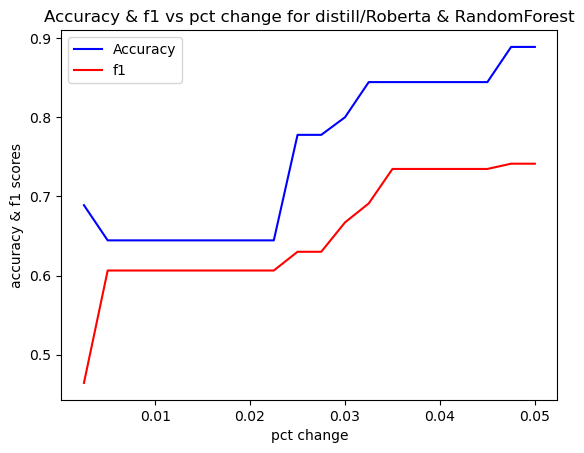

In [15]:
fig, ax = plt.subplots()
ax.plot(priceloop_df['price_x'], priceloop_df['accuracyscores'], label='Accuracy', color='blue')
ax.plot(priceloop_df['price_x'], priceloop_df['f1score'], label='f1',color='red')
plt.xlabel('pct change')
plt.ylabel('accuracy & f1 scores')
plt.title('Accuracy & f1 vs pct change for distill/Roberta & RandomForest')
plt.legend()
plt.show()

<h1>Distill/Roberta NLP model with K-Nearest Neighbours Model Training & Testing</h1>

In [21]:
#KNN model
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import precision_recall_fscore_support, f1_score
from sklearn.preprocessing import StandardScaler

best_f1 = 0
best_score = 0
price_x=[]
accuracyscoreset = []
f1scoreset = []
majority_ratioset = [] #To check whether imbalance data, majority:Minority>4 considered imbalanced
best_params_set = []
#knn = KNeighborsClassifier()

for i in range(1,21):
    x = i/400 #0.0025% incremental loop for pct change
    def price_cat(price):
        if price > x:
            return 'buy'
        elif price < -x:
            return 'sell'
        else:
            return 'neutral'
    
     #close_price_df['signal'] = close_price_df['pct_change'].apply(price_cat)
    merged_df['signal'] = merged_df['pct_change'].apply(price_cat)
        
    close_price_df['signal'] = close_price_df['pct_change'].apply(price_cat)
    dr_output_df['date'] = pd.to_datetime(dr_output_df['date'])
    merged_df = pd.merge(close_price_df, dr_output_df, left_on='Date', right_on='date', how='inner')
    merged_df = merged_df.drop(['date','Close'],axis=1)
    
    from sklearn.preprocessing import LabelEncoder
    le = LabelEncoder()
    merged_df['signal_encoded'] = le.fit_transform(merged_df['signal'])
    
    columns = ['positive_aggscore', 'neutral_aggscore', 'negative_aggscore','positive_count','neutral_count','negative_count']
    X = merged_df[columns]
    y = merged_df['signal_encoded']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    scaler = StandardScaler()
    X_train[columns] = scaler.fit_transform(X_train[columns])
    X_test[columns] = scaler.transform(X_test[columns]) #scaled by fitting scale of X_train

    
    #Step3: Define and train the KNN model, perform grid search to find best value of n
    
    #param_grid = {'n_neighbors': range(1, round(math.sqrt(len(merged_df))))}
    #grid_search = GridSearchCV(knn, param_grid, cv=5)
    #grid_search.fit(X_train, y_train)
    #best_k = grid_search.best_params_['n_neighbors']

    #knn_model = KNeighborsClassifier(n_neighbors=best_k)  # You can adjust the number of neighbors as needed
    #knn_model.fit(X_train, y_train)
    

    for neighbor in range(1, round(math.sqrt(len(merged_df)))):
            knn_model = KNeighborsClassifier(n_neighbors=neighbor)
            knn_model.fit(X_train, y_train)

            y_pred = knn_model.predict(X_test)
            f1 = f1_score(y_test,y_pred, average="macro")
            score = knn_model.score(X_test, y_test)
            try:
                if  score > best_score and f1 > best_f1:
                        best_f1 = f1
                        best_parameters = neighbor
                        best_score=score

            except Exception as error:
                    print("An exception occurred:", error)

# Step 4: Make predictions on the testing set
#'''
   # y_pred = knn_model.predict(X_test)
   # f1 = f1_score(y_test,y_pred, average="weighted")
   # score = knn_model.score(X_test, y_test)
   # try:
      #  if f1 > best_f1:
          #          y_pred = knn_model.predict(X_test)
           #         best_score =  knn_model.score(X_test, y_test)
           #         best_f1 = f1
           #         best_parameter = best_k


    #except Exception as error:
    #    print("An exception occurred:", error)
#'''       
                            
    majority_ratio = len(merged_df[merged_df['signal_encoded'] == 1]) / len(merged_df[merged_df['signal_encoded'] == 2])                        
    price_x.append(x)
    accuracyscoreset.append(best_score)
    f1scoreset.append(best_f1)
    majority_ratioset.append(majority_ratio)
    best_params_set.append(best_parameters)                      


priceloop_df_4 = pd.DataFrame({'price_x': price_x,'accuracyscores': accuracyscoreset,'f1score': f1scoreset,'majority_ratio': majority_ratioset,'best_k': best_params_set})
priceloop_df_4

,price_x,accuracyscores,f1score,majority_ratio,best_k
0,0.0025,0.622222,0.418942,0.123711,10
1,0.0050,0.622222,0.418942,0.348315,10
2,0.0075,0.622222,0.418942,0.554217,10
3,0.0100,0.622222,0.418942,0.837838,10
4,0.0125,0.622222,0.418942,1.169231,10
5,0.0150,0.622222,0.418942,1.568966,10
6,0.0175,0.622222,0.418942,2.270833,10
7,0.0200,0.622222,0.418942,2.644444,10
8,0.0225,0.622222,0.418942,3.648649,10
9,0.0250,0.733333,0.606061,3.972222,5


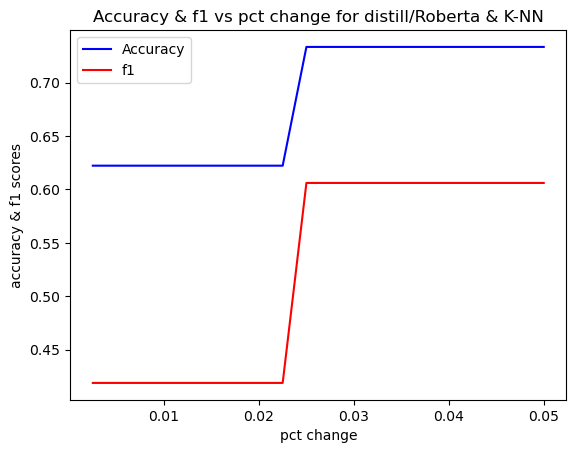

In [23]:
fig, ax = plt.subplots()
ax.plot(priceloop_df_4['price_x'], priceloop_df_4['accuracyscores'], label='Accuracy', color='blue')
ax.plot(priceloop_df_4['price_x'], priceloop_df_4['f1score'], label='f1',color='red')
plt.xlabel('pct change')
plt.ylabel('accuracy & f1 scores')
plt.title('Accuracy & f1 vs pct change for distill/Roberta & K-NN')
plt.legend()
plt.show()

<h1>Comparison of all models' performance</h1>

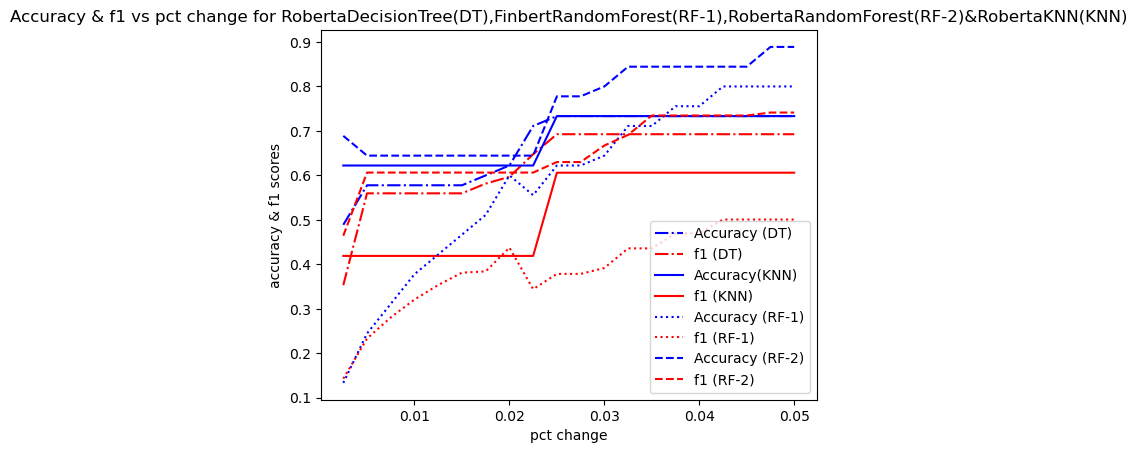

In [25]:
fig, ax = plt.subplots()
ax.plot(priceloop_df_3['price_x'], priceloop_df_3['accuracyscores'], label='Accuracy (DT)', color='blue',linestyle='-.')
ax.plot(priceloop_df_3['price_x'], priceloop_df_3['f1score'], label='f1 (DT)',color='red', linestyle='-.')
ax.plot(priceloop_df_4['price_x'], priceloop_df_4['accuracyscores'], label='Accuracy(KNN)', color='blue',linestyle='-')
ax.plot(priceloop_df_4['price_x'], priceloop_df_4['f1score'], label='f1 (KNN)',color='red',linestyle='-')
ax.plot(priceloop_df_2['price_x'], priceloop_df_2['accuracyscores'], label='Accuracy (RF-1)', color='blue',linestyle=':')
ax.plot(priceloop_df_2['price_x'], priceloop_df_2['f1score'], label='f1 (RF-1)',color='red', linestyle=':')
ax.plot(priceloop_df['price_x'], priceloop_df['accuracyscores'], label='Accuracy (RF-2)', color='blue',linestyle='--')
ax.plot(priceloop_df['price_x'], priceloop_df['f1score'], label='f1 (RF-2)',color='red', linestyle='--')
plt.xlabel('pct change')
plt.ylabel('accuracy & f1 scores')
plt.title('Accuracy & f1 vs pct change for RobertaDecisionTree(DT),FinbertRandomForest(RF-1),RobertaRandomForest(RF-2)&RobertaKNN(KNN)')
plt.legend()
plt.show()

<h1>Distill/Roberta NLP model with Random Forest Classifier Final Tuning</h1>

In [19]:
#Running the best model:RandomForest with best parameters & pct change
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_recall_fscore_support, f1_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

best_f1 = 0

def price_cat(price):
    if price > 0.0475:
        return 'buy'
    elif price < -0.0475:
        return 'sell'
    else:
        return 'neutral'
        
close_price_df['signal'] = close_price_df['pct_change'].apply(price_cat)
dr_output_df['date'] = pd.to_datetime(dr_output_df['date'])
merged_df = pd.merge(close_price_df, dr_output_df, left_on='Date', right_on='date', how='inner')
merged_df = merged_df.drop(['date','Close'],axis=1)
    
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
merged_df['signal_encoded'] = le.fit_transform(merged_df['signal'])
    
columns = ['positive_aggscore', 'neutral_aggscore', 'negative_aggscore','positive_count','neutral_count','negative_count']
X = merged_df[columns]
y = merged_df['signal_encoded']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#scaling of dependent variables
scaler = StandardScaler()
X_train[columns] = scaler.fit_transform(X_train[columns])
X_test[columns] = scaler.transform(X_test[columns]) 
    
    #Tuning of Random Forest Classification model parameters
for criterion in ['gini', 'entropy']:
    for n_estimator in [200, 300, 400]:
        for max_depth in [None, 10, 20]:
            for min_samples_split in [5, 10,20]:
                for min_samples_leaf in [1,2,4]:
                    try:
                        clf = RandomForestClassifier(criterion=criterion, n_estimators=n_estimator,max_depth=max_depth,min_samples_split=min_samples_split,min_samples_leaf=min_samples_leaf)
                        clf.fit(X_train, y_train)
                        y_pred = clf.predict(X_test)
                        f1 = f1_score(y_test, y_pred, average="macro")
    
                        if f1 > best_f1:
                            best_score = clf.score(X_test, y_test)
                            best_parameters = {'criterion': criterion, 'n_estimator': n_estimator, 'max_depth': max_depth, 'min_samples_split': min_samples_split,'min_samples_leaf': min_samples_leaf}
                            y_pred = clf.predict(X_test)
                            best_f1 = f1
                            best_clf = clf
                                
                    except Exception as error:
                        print("An exception occurred:", error)

<h1>Export Model as pickle file for Flask Deployment</h1>

In [ ]:
import joblib

joblib.dump(best_clf, 'senTEAMentanalysis.pkl')